# in this second version of CNN I will 

      1° balance train and dev data 
      2° give equal weights to all target classes
      3° increase training  epochs
      4° decrease training  batch size

In [1]:
!pip install gensim
!pip install nltk

  Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
  Using cached smart_open-6.4.0-py3-none-any.whl.metadata (21 kB)
Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
Using cached smart_open-6.4.0-py3-none-any.whl (57 kB)


In [4]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import time
import re
import random
from keras import regularizers


# Initialisation du générateur de nombres aléatoires
random.seed(123)

tokenizer = nltk.RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [3]:
import nltk

# Télécharge les données nécessaires pour le tokenizer (segmenteur) de phrases et de mots
nltk.download('punkt')

# Télécharge la liste de mots vides (stopwords) pour différentes langues
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
train_data = pd.read_csv('cleaned_data/train_cleaned.csv',index_col=0)
dev_data   = pd.read_csv('cleaned_data/dev_cleaned.csv',index_col=0)
test_data  =  pd.read_csv('cleaned_data/test_cleaned.csv',index_col=0)

In [5]:
# GET ONLY 1/4 OF TRAIN AND DEV DATA DUE TO COMPUTATION RESOURCES LIMITATIONS
# train_data = train_data.head(200)
# dev_data = dev_data.head(50)


In [6]:
train_data['note'].value_counts()

7    124656
6     97443
5     94103
9     75903
8     64296
4     58719
3     55285
0     38372
1     30236
2     26949
Name: note, dtype: int64

In [7]:
dev_data['note'].value_counts()

7    18594
6    14333
5    13881
9    12906
8     9945
4     8289
3     8110
0     5835
1     4547
2     3960
Name: note, dtype: int64

In [8]:
# get the same minority classe size in all other classes in train and dev data 

from sklearn.utils import resample, class_weight


# Calculez la taille de la classe minoritaire
train_minority_class_size = min(train_data['note'].value_counts())
dev_minority_class_size = min(dev_data['note'].value_counts())

# Sous-échantillonnez les classes majoritaires pour avoir la même taille que la classe minoritaire
train_data = pd.concat([
    resample(train_data[train_data['note'] == note], replace=True, n_samples=train_minority_class_size)
    for note in train_data['note'].unique()
])

dev_data = pd.concat([
    resample(dev_data[dev_data['note'] == note], replace=True, n_samples=dev_minority_class_size)
    for note in dev_data['note'].unique()
])


In [9]:
train_data['note'].value_counts()

7    26949
6    26949
8    26949
5    26949
1    26949
4    26949
9    26949
3    26949
0    26949
2    26949
Name: note, dtype: int64

In [10]:
dev_data['note'].value_counts()

9    3960
6    3960
7    3960
3    3960
8    3960
5    3960
0    3960
4    3960
1    3960
2    3960
Name: note, dtype: int64

In [11]:
train_data['commentaire'] = train_data['commentaire'].astype(str)
dev_data['commentaire'] = dev_data['commentaire'].astype(str)
test_data['commentaire'] = test_data['commentaire'].astype(str)

In [12]:
train_comments_list = train_data['commentaire'].values.tolist()
dev_comments_list  = dev_data['commentaire'].values.tolist()
test_comments_list  = test_data['commentaire'].values.tolist()

In [13]:
corpus_all_comments = train_comments_list + dev_comments_list + test_comments_list

In [14]:
corpus_all_comments

['excellente surprise film malgré debut film peu déroutant premier passé rentre décors fantastiques retrouve valerien bercé jeunesse acteurs intrigues tout voir bravo ciné français',
 'film procès dynamique thriller ajout narration personnage nora renforce intérêt sujet traité sort potentiel huit clos marina fois excellente rôle incarnant parfaitement personnage sied gourmet magistrale notamment plaidoyé général aussi habilement écrit interprété immense justesse mise scène aussi parfaitement maîtrisée rythme intensité émotion etc affaire aussi intéressante intriguante ouvrant certain nombres questions réel coupable véritable issue tragique cette femme éléments traités tout porte croire spoiler malheureusement bien morte amant pourrait bien être responsable vues contexte tant oeuvre manipulation grande ampleur',
 'épisode plus sombre saga harry potter quand suite très efficace autant dire après avoir zappé tomes après avoir harry potter prince sang mêlé trouvé bien hauteur autres films 

# Corpus Tokenization

In [15]:
from nltk.tokenize import word_tokenize

tokens = [word_tokenize(sentence) for sentence in corpus_all_comments]
tokens

[['excellente',
  'surprise',
  'film',
  'malgré',
  'debut',
  'film',
  'peu',
  'déroutant',
  'premier',
  'passé',
  'rentre',
  'décors',
  'fantastiques',
  'retrouve',
  'valerien',
  'bercé',
  'jeunesse',
  'acteurs',
  'intrigues',
  'tout',
  'voir',
  'bravo',
  'ciné',
  'français'],
 ['film',
  'procès',
  'dynamique',
  'thriller',
  'ajout',
  'narration',
  'personnage',
  'nora',
  'renforce',
  'intérêt',
  'sujet',
  'traité',
  'sort',
  'potentiel',
  'huit',
  'clos',
  'marina',
  'fois',
  'excellente',
  'rôle',
  'incarnant',
  'parfaitement',
  'personnage',
  'sied',
  'gourmet',
  'magistrale',
  'notamment',
  'plaidoyé',
  'général',
  'aussi',
  'habilement',
  'écrit',
  'interprété',
  'immense',
  'justesse',
  'mise',
  'scène',
  'aussi',
  'parfaitement',
  'maîtrisée',
  'rythme',
  'intensité',
  'émotion',
  'etc',
  'affaire',
  'aussi',
  'intéressante',
  'intriguante',
  'ouvrant',
  'certain',
  'nombres',
  'questions',
  'réel',
  'cou

# W2V_Skip-gram

In [16]:
#  objectif : Prédire le contexte (les mots qui entourent) à partir d'un mot cible.
#  Utilisation : Performant pour des corpus textuels où le sens des mots est relativement stable sur de courtes fenêtres.

In [17]:
# from gensim.models import Word2Vec

# # Modèle Word2Vec avec Skip-gram
# Word2Vec_model_skipgram = Word2Vec(sentences=tokens, vector_size=100, window=5, sg=1, min_count=1, epochs=10)

# # Sauvegarde du modèle
# Word2Vec_model_skipgram.save("Word2Vec_Skipgram.model")


In [18]:
#!pip install gensim

# W2V_CBOW

In [19]:
#  Prédire un mot cible à partir de son contexte (les mots qui l'entourent).
#  Utilisation : Performant pour des corpus textuels où le sens des mots est relativement stable sur de courtes fenêtres. 

In [20]:
from gensim.models import Word2Vec

Word2Vec_model_cbow = Word2Vec(tokens, vector_size=100, min_count=1, epochs=10, sg=0)

Word2Vec_model_cbow.save("Word2Vec_CBOW.model")

In [21]:
Word2Vec_CBOW = Word2Vec.load("Word2Vec_CBOW.model")

In [22]:
vector = Word2Vec_CBOW.wv['film']  # get numpy vector of a 'film' word
vector

array([ 1.0993196 , -1.769444  ,  0.45642343,  2.1623769 , -1.0367525 ,
        2.0387983 , -1.0542598 , -1.9334775 , -0.06039934,  0.79368573,
        1.3943883 ,  1.8493481 , -1.482165  ,  0.59249747, -1.7824675 ,
        0.97660196, -0.2541065 ,  1.9965318 , -2.6082065 ,  2.9992425 ,
       -0.72140044, -0.25361785,  0.39472988,  0.3557068 ,  0.08853836,
       -1.1687328 ,  1.2102934 ,  3.0464313 ,  1.3318893 , -1.5619912 ,
       -3.2118566 , -0.1206049 ,  1.031431  ,  0.67004216,  0.34881762,
       -2.344318  ,  1.0648507 ,  2.0324652 ,  0.72428364,  2.1706326 ,
       -1.5108222 ,  0.693812  ,  0.6278825 ,  1.0910279 , -3.6624117 ,
       -0.57406354, -0.87336415,  0.1331662 ,  0.99568105,  0.6936091 ,
       -1.0977223 ,  1.5850468 ,  0.48907706,  0.19696675,  0.26158985,
       -1.7955041 , -0.9969041 , -0.6643262 , -0.4256071 , -0.1833475 ,
       -0.87702185,  0.7810123 , -1.0108173 , -0.98584884,  1.8514551 ,
       -0.83326757, -2.1160305 , -0.15610875, -0.40358233, -1.90

In [23]:
def limit_comment_length(comment, max_words=100):
    # Diviser le commentaire en mots
    words = comment.split()
    
    # Limiter le nombre de mots
    limited_words = words[:max_words]
    
    # Rejoindre les mots pour former un nouveau commentaire
    limited_comment = ' '.join(limited_words)
    
    return limited_comment

# Appliquer la fonction à chaque commentaire dans train_comments_list et dev_comments_list
train_list = [limit_comment_length(comment) for comment in train_comments_list if comment]
dev_list = [limit_comment_length(comment) for comment in dev_comments_list if comment]


In [24]:
def count_words(message):
    # Diviser la chaîne en une liste de mots
    words = message.split()
    
    # Compter le nombre de mots
    num_words = len(words)
    
    return num_words

# Exemple d'utilisation
result = count_words(train_list[0])

print("Nombre de mots dans le message :", result)


Nombre de mots dans le message : 24


In [25]:
train_data['nouvelle commentaire'] = train_list
dev_data['nouvelle commentaire']   = dev_list

In [26]:
train_data['nouvelle commentaire']

499879    excellente surprise film malgré debut film peu...
636341    film procès dynamique thriller ajout narration...
522059    épisode plus sombre saga harry potter quand su...
228471    plaisir contempler disney quelque nouveauté su...
174790    très bon film aventure actrice vraiment charis...
                                ...                        
141225    tellement déçu adèle exarchopoulos reproduit i...
574468    succession clichés incohérences scénaristiques...
477501    pseudo film horreur non dénué qualité actrice ...
550340    très beau étrange poétique bien sûr incohérent...
47534     quelle tristesse excellent plus avance épisode...
Name: nouvelle commentaire, Length: 269490, dtype: object

In [27]:
# train data sise : 665962

In [28]:
X_train = train_data['nouvelle commentaire']
X_dev   = dev_data['nouvelle commentaire']

# return the most 'len(X_train) = 665962' frequent words id
tokenizer = Tokenizer(num_words=len(list(X_train.unique())))

# entrainer le tokenizer
tokenizer.fit_on_texts(list(X_train))

#mapping of words to ids for the entire text corpus
word_index = tokenizer.word_index

# Return a vector of ids of the most 'len(X_train) = 665962' in each comment
X_train = tokenizer.texts_to_sequences(X_train) 
X_dev = tokenizer.texts_to_sequences(X_dev)

# Ensure that all sequences in a list have the same length, if not add 0 at begining
X_train = pad_sequences(X_train, maxlen=100)
X_dev = pad_sequences(X_dev, maxlen=100)

# save tokenizer

In [29]:
import pickle

# Sauvegarder le tokenizer
with open('Cnn_tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


In [30]:
word_index

{'film': 1,
 'plus': 2,
 'bien': 3,
 'très': 4,
 'tout': 5,
 'histoire': 6,
 'sans': 7,
 'fait': 8,
 'peu': 9,
 'bon': 10,
 'comme': 11,
 'scénario': 12,
 'voir': 13,
 'acteurs': 14,
 'cette': 15,
 'être': 16,
 'trop': 17,
 'vraiment': 18,
 'faire': 19,
 'aussi': 20,
 'rien': 21,
 'fin': 22,
 'peut': 23,
 'personnages': 24,
 'assez': 25,
 'scènes': 26,
 'beaucoup': 27,
 'mal': 28,
 'scène': 29,
 'reste': 30,
 'deux': 31,
 'films': 32,
 'grand': 33,
 'fois': 34,
 'car': 35,
 'quand': 36,
 'tous': 37,
 'entre': 38,
 'quelques': 39,
 'encore': 40,
 'moment': 41,
 'moins': 42,
 'action': 43,
 'après': 44,
 'cela': 45,
 'dire': 46,
 'temps': 47,
 'cinéma': 48,
 'toujours': 49,
 'plutôt': 50,
 'long': 51,
 'donc': 52,
 'alors': 53,
 'non': 54,
 'premier': 55,
 'humour': 56,
 'surtout': 57,
 'bonne': 58,
 'comédie': 59,
 'personnage': 60,
 'vie': 61,
 'genre': 62,
 'autres': 63,
 'avoir': 64,
 'chose': 65,
 'rôle': 66,
 'réalisateur': 67,
 'bref': 68,
 'juste': 69,
 'déjà': 70,
 'mise': 71,
 

In [31]:
X_train

array([[   0,    0,    0, ...,  475,  835,  197],
       [   0,    0,    0, ..., 3395,  149, 2707],
       [ 383,    2,  419, ...,   25,  503,  126],
       ...,
       [   0,    0,    0, ...,   11,  155, 5979],
       [   0,    0,    0, ...,   48,  871, 4414],
       [   0,    0,    0, ...,   86,    3,   87]], dtype=int32)

In [32]:
vocab_size = len(word_index) + 1
vocab_size

126396

In [33]:
import numpy as np

# Return a matix of vocab words embedding based using Word2Vec_CBOW 
def create_embedding_matrix(tokenizer, word2vec_model, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        try:
            vector = word2vec_model.wv[word]
        except KeyError:
            # Word not found in Word2Vec, keep the embedding as zeros
            continue
        embedding_matrix[i] = vector

    return embedding_matrix

In [34]:
embedding_matrix = create_embedding_matrix(tokenizer, Word2Vec_CBOW, 100)
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.09931958, -1.76944399,  0.45642343, ...,  0.37636811,
         1.33383811,  0.80937588],
       [ 0.70843208, -2.2045126 ,  0.66761154, ...,  1.43846202,
        -0.33427894, -0.79372758],
       ...,
       [ 0.00929895,  0.03844559, -0.02439836, ...,  0.01015943,
         0.0293598 , -0.0336905 ],
       [ 0.07545918, -0.01291525,  0.03336289, ...,  0.04038091,
        -0.00695745, -0.04757187],
       [-0.06680336, -0.0476998 ,  0.05850261, ..., -0.03613422,
         0.01342733, -0.00492101]])

In [35]:
y_train = np.array(train_data['note'])
y_train = y_train.astype(int)
y_train

array([7, 7, 7, ..., 2, 2, 2])

In [36]:
y_dev = np.array(dev_data['note'])
y_dev = y_dev.astype(int)
y_dev

array([9, 9, 9, ..., 2, 2, 2])

# CNN + Word2Vec_CBOW

In [37]:
classes_num = 10

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, GlobalMaxPool1D

dropout_rate=0.25

# Create a sequential model
model = Sequential()

# Add an Embedding layer to the model
model.add(Embedding(
    input_dim=vocab_size,         # Vocabulary size, total number of unique words in the data
    output_dim=100,               # Dimension of the embedding space, each word represented by a vector of 100 dimensions
    input_length=100,             # Length of each input sequence (comment), limited to 100 words
    weights=[embedding_matrix],   # Initialize the embedding layer with pre-trained weights from embedding_matrix
    trainable=True                # Allow the weights of the embedding layer to be trainable during model training
))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu',kernel_regularizer=regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(GlobalMaxPool1D())
model.add(Dropout(dropout_rate))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Dense(10, activation='softmax'))



# IMPROVEMENT
# give equal class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# Convert class weights to a dictionary for use with Keras
class_weight_dict = dict(enumerate(class_weights))


# Compile the model
#  sparse_categorical_crossentropy loss function used during training. For a classification task with integer labels (like 0, 1, 2),
# for that i converted nmarks from 0.5,1...5 to 0,1...9
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Specify the file path where the best model will be saved
filepath = 'CNN_Word2Vec_SkipGram_Best_One_improved.hdf5'

# Create callbacks
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

callbacks = [checkpoint, early_stopping]

start_time = time.time()


# Train for more epochs
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_dev, y_dev),
    epochs=20,  # Increase the number of epochs
    batch_size=32,  # Experiment with different batch sizes
    verbose=1,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

execution_time = time.time() - start_time

print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(execution_time)))




2024-01-04 16:25:27.318228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          12639600  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 batch_normalization (Batch  (None, 96, 128)           512       
 Normalization)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8422/8422 [==============================] - 1533s 182ms/step - loss: 2.0557 - accuracy: 0.2835 - val_loss: 1.8540 - val_accuracy: 0.3241
Epoch 2/20
8422/8422 [==============================] - ETA: 0s - loss: 1.8772 - accuracy: 0.3174
Epoch 2: val_accuracy improved from 0.32412 to 0.33472, saving model to CNN_Word2Vec_SkipGram_Best_One_improved.hdf5
8422/8422 [==============================] - 1534s 182ms/step - loss: 1.8772 - accuracy: 0.3174 - val_loss: 1.8273 - val_accuracy: 0.3347
Epoch 3/20
8422/8422 [==============================] - ETA: 0s - loss: 1.8406 - accuracy: 0.3289
Epoch 3: val_accuracy improved from 0.33472 to 0.33770, saving model to CNN_Word2Vec_SkipGram_Best_One_improved.hdf5
8422/8422 [==============================] - 1520s 180ms/step - loss: 1.8406 - accuracy: 0.3289 - val_loss: 1.8120 - val_accuracy: 0.3377
Epoch 4/20
8422/8422 [==============================] - ETA: 0s - loss: 1.8137 - accuracy: 0.3404
Epoch 4: val_accuracy did not improve from 0.33770
8422/84

# save train and validation accuracy/loss

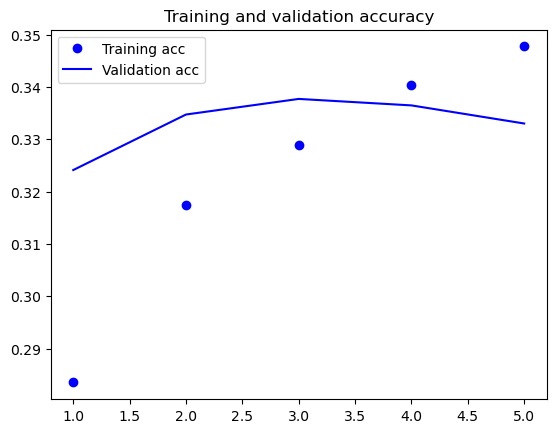

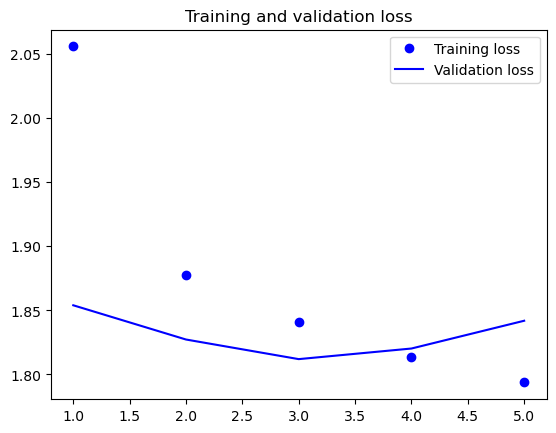

In [39]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Cnn_accuracy_plot.png')  # Save the plot as an image

# Clear the figure for the next plot
plt.figure()

# Plot loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Cnn_loss_plot.png')  # Save the plot as an image


In [2]:
# Charger le tokenizer depuis le fichier
import pickle

with open('Cnn_tokenizer.pkl', 'rb') as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)

# Test and saving predictions

In [3]:
from tensorflow.keras.models import load_model

# model = load_model('MLP_Best_One.hdf5'),this command doesn't work for me, i had to change the saved model path

modelpath = "C:/trained_Models/CNN_Word2Vec_SkipGram_Best_One_improved.hdf5"

# Load the model with compile=False
CNN_Word2Vec_SkipGram_Best_One_improved = load_model(modelpath)


In [42]:
# model

In [7]:
test_data['commentaire'] = test_data['commentaire'].astype(str)
X_test = test_data['commentaire']

In [8]:
# X_test = tokenizer.texts_to_sequences(X_test)

X_test = loaded_tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=100)

In [9]:
X_test

array([[ 2274, 13568, 50988, ...,   370,    19,     2],
       [    0,     0,     0, ...,  1220,   155,    13],
       [   89,  1752,  7048, ...,    89,   524, 10784],
       ...,
       [    0,     0,     0, ...,     9,   417,   111],
       [    0,     0,     0, ...,   157,   161,    10],
       [    0,     0,     0, ...,   504,  1249,   874]])

In [10]:
predictions = CNN_Word2Vec_SkipGram_Best_One_improved.predict(X_test)
predictions

2683/2683 [==============================] - 14s 5ms/step


array([[1.54681485e-02, 2.55897567e-02, 3.29774655e-02, ...,
        1.75448388e-01, 1.21887289e-01, 1.04661800e-01],
       [5.67621738e-02, 7.04599321e-02, 7.20757321e-02, ...,
        1.21848881e-01, 8.37955922e-02, 7.96404853e-02],
       [7.45343370e-03, 7.52135739e-03, 8.00199527e-03, ...,
        1.55432642e-01, 3.28906417e-01, 3.88196111e-01],
       ...,
       [1.17557327e-04, 5.18379151e-04, 1.21102214e-03, ...,
        2.43642882e-01, 5.67979924e-02, 2.23146696e-02],
       [3.92888440e-03, 4.35123267e-03, 4.84177889e-03, ...,
        1.66556478e-01, 3.20794195e-01, 3.66892219e-01],
       [2.84850597e-03, 2.41739885e-03, 2.38960236e-03, ...,
        1.16433658e-01, 3.43470931e-01, 4.82080370e-01]], dtype=float32)

In [11]:
argmax_predictions = np.argmax(predictions,axis =1)
argmax_predictions

array([6, 5, 9, ..., 6, 9, 9], dtype=int64)

In [12]:
#  generate the plateform test data format        
with open("CNN_Word2Vec_SkipGram_improved_ID_Prediction.txt", "w") as f:
    for i in range(len(test_data['review_id'])):
        prediction = (argmax_predictions[i] + 1) / 2
        line = f"{test_data['review_id'].iloc[i]} {str(prediction).replace('.', ',')}\n"
        f.write(line)